# 1. Import Required Libraries

In [39]:
# 1. Import required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from skimage.feature import local_binary_pattern, hog, canny
from skimage.exposure import equalize_hist
from skimage.filters import gaussian
from skimage import img_as_float
from skimage.measure import label

from torchvision.datasets import EMNIST
from torchvision import transforms
from torchvision.transforms import functional as TF

import torch

# Make experiments reproducible
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)


# 2. Data Acquisition – Load EMNIST Letters

In [40]:
# 2. Data acquisition: load EMNIST Letters

# Transform: undo EMNIST rotation/mirror so letters are upright, then convert to tensor
transform = transforms.Compose([
    # EMNIST letters are rotated + mirrored in the raw files; undo this so training matches human-written orientation
    transforms.Lambda(lambda img: TF.rotate(img, -90)),
    transforms.Lambda(lambda img: TF.hflip(img)),
    transforms.ToTensor()
])

# Download EMNIST letters split
train_dataset = EMNIST(
    root="data",
    split="letters",
    train=True,
    download=True,
    transform=transform
)

test_dataset = EMNIST(
    root="data",
    split="letters",
    train=False,
    download=True,
    transform=transform
)

len(train_dataset), len(test_dataset)


(124800, 20800)

# 2.1 Convert Datasets to Numpy & (Optionally) Sample 10k–20k Images

In [41]:
# Helper: convert a torchvision dataset to numpy arrays
def dataset_to_numpy(dataset, max_samples=None, seed=42):
    rng = np.random.RandomState(seed)
    n = len(dataset)
    if max_samples is not None and max_samples < n:
        indices = rng.choice(n, size=max_samples, replace=False)
    else:
        indices = np.arange(n)

    images = []
    labels = []
    for idx in indices:
        img_tensor, label = dataset[idx]   # img_tensor: [1, 28, 28]
        img = img_tensor.squeeze(0).numpy()  # -> (28, 28)
        images.append(img)
        labels.append(label)

    return np.array(images), np.array(labels)

# Take 20k samples from train data
X_images, y_raw = dataset_to_numpy(train_dataset, max_samples=20000)

X_images.shape, y_raw.shape


((20000, 28, 28), (20000,))

# 2.2 Map Labels to A–Z and Show Distribution

Total samples: 20000
Number of classes: 26


,label,count
0,A,823
1,B,733
2,C,790
3,D,744
4,E,736


Class 0 (A): 823
Class 1 (B): 733
Class 2 (C): 790
Class 3 (D): 744
Class 4 (E): 736
Class 5 (F): 781
Class 6 (G): 732
Class 7 (H): 737
Class 8 (I): 755
Class 9 (J): 781
Class 10 (K): 785
Class 11 (L): 767
Class 12 (M): 755
Class 13 (N): 759
Class 14 (O): 742
Class 15 (P): 791
Class 16 (Q): 787
Class 17 (R): 808
Class 18 (S): 757
Class 19 (T): 802
Class 20 (U): 782
Class 21 (V): 781
Class 22 (W): 774
Class 23 (X): 748
Class 24 (Y): 765
Class 25 (Z): 785


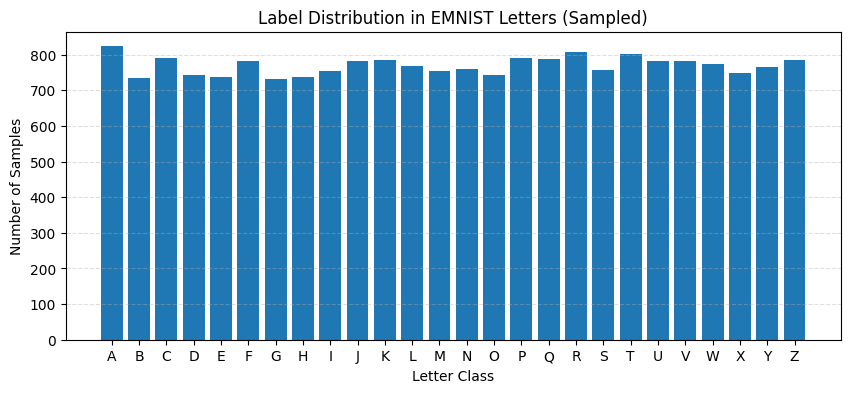

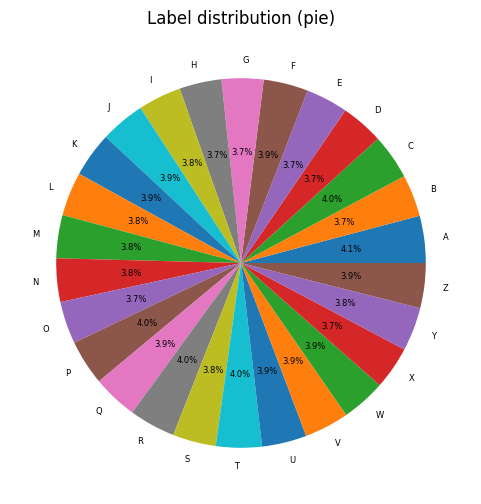

In [42]:
# EMNIST letters labels are 1-26; we map them to 0-25 internally
y = y_raw - 1  # now in [0, 25]

# Helper to map numeric label to actual letter (A-Z)
def idx_to_char(idx):
    return chr(ord('A') + idx)

# Dataset size and category-wise count
unique, counts = np.unique(y, return_counts=True)
print("Total samples:", len(y))
print("Number of classes:", len(unique))

distribution_df = pd.DataFrame({"label": [idx_to_char(i) for i in unique], "count": counts})
display(distribution_df.head())

for cls, cnt in zip(unique, counts):
    print(f"Class {cls} ({idx_to_char(cls)}): {cnt}")

# Plot label distribution
plt.figure(figsize=(10, 4))
plt.bar([idx_to_char(i) for i in unique], counts)
plt.xlabel("Letter Class")
plt.ylabel("Number of Samples")
plt.title("Label Distribution in EMNIST Letters (Sampled)")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()

plt.figure(figsize=(6, 6))
plt.pie(counts, labels=[idx_to_char(i) for i in unique], autopct='%1.1f%%', textprops={'fontsize':6})
plt.title("Label distribution (pie)")
plt.show()


# 3. Data Preparation – Train/Test Split

We perform an 80/20 stratified split on the sampled images so every letter keeps its proportion in both train and test sets. This matches the rubric requirement for a balanced evaluation pipeline.


In [43]:
# 3. Train-test split (stratified)

X_train_imgs, X_test_imgs, y_train, y_test = train_test_split(
    X_images,
    y,
    test_size=0.2,
    stratify=y,
    random_state=SEED
)

print(f'Train images: {len(X_train_imgs)} | Test images: {len(X_test_imgs)}')
print(f'Class distribution preserved (train): {np.bincount(y_train)}')
print(f'Class distribution preserved (test): {np.bincount(y_test)}')


Train images: 16000 | Test images: 4000
Class distribution preserved (train): [658 586 632 595 589 625 586 590 604 625 628 613 604 607 594 633 630 646
 606 641 626 625 619 598 612 628]
Class distribution preserved (test): [165 147 158 149 147 156 146 147 151 156 157 154 151 152 148 158 157 162
 151 161 156 156 155 150 153 157]


# 4. Preprocessing & Feature Engineering

In [44]:
# 4. Feature engineering

# Parameters for LBP
LBP_RADIUS = 1
LBP_POINTS = 8 * LBP_RADIUS
LBP_METHOD = "uniform"

def extract_features_single(img_28x28):
    """
    img_28x28: numpy array (28x28), values in [0,1] or [0,255]
    Returns: 1D feature vector (np.array)
    """
    # Ensure float in [0,1]
    img = img_as_float(img_28x28)

    # --- Low-level preprocessing ---

    # 1) Histogram equalization (improves contrast)
    img_eq = equalize_hist(img)

    # 2) Gaussian smoothing to reduce noise
    img_smooth = gaussian(img_eq, sigma=1)

    # --- Mid-level features ---

    # A) Edge map using Canny
    edges = canny(img_smooth, sigma=1)
    edge_density = edges.mean()  # fraction of edge pixels

    # B) Connected components on edge image
    labeled = label(edges)
    num_components = labeled.max()  # 0 if no edges

    # C) LBP texture descriptor
    lbp = local_binary_pattern(img_smooth, LBP_POINTS, LBP_RADIUS, method=LBP_METHOD)
    n_bins = LBP_POINTS + 2  # uniform LBP
    lbp_hist, _ = np.histogram(
        lbp.ravel(),
        bins=n_bins,
        range=(0, n_bins),
        density=True  # normalized histogram
    )

    # D) HOG descriptor (gradient-based shape descriptor)
    hog_feat = hog(
        img_smooth,
        orientations=9,
        pixels_per_cell=(7, 7),
        cells_per_block=(2, 2),
        block_norm="L2-Hys",
        transform_sqrt=True,
        feature_vector=True
    )

    # Concatenate all features into a single vector
    feature_vector = np.hstack([
        lbp_hist,
        hog_feat,
        [edge_density, num_components]
    ])

    return feature_vector


# 4.2 Apply Feature Extraction to All Train & Test Images

In [45]:
# Apply feature extraction to all images
def build_feature_matrix(images):
    features = [extract_features_single(img) for img in images]
    return np.vstack(features)

print('Extracting features for training set...')
X_train = build_feature_matrix(X_train_imgs)
print('Extracting features for test set...')
X_test = build_feature_matrix(X_test_imgs)

X_train.shape, X_test.shape


Extracting features for training set...


/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Extracting features for test set...


((16000, 336), (4000, 336))

# 5. Model Building – kNN, SVM, RF, Logistic Regression

In [46]:
# 5. Model building

models = {
    "kNN": make_pipeline(
        StandardScaler(),
        KNeighborsClassifier(n_neighbors=5)
    ),
    "SVM (RBF)": make_pipeline(
        StandardScaler(),
        SVC(kernel="rbf", C=10, gamma="scale")
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ),
    "LogisticRegression": make_pipeline(
        StandardScaler(),
        LogisticRegression(
            max_iter=1000,
            multi_class="multinomial",
            n_jobs=-1
        )
    )
}

models


{'kNN': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('kneighborsclassifier', KNeighborsClassifier())]),
 'SVM (RBF)': Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC(C=10))]),
 'RandomForest': RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42),
 'LogisticRegression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(max_iter=1000, multi_class='multinomial',
                                     n_jobs=-1))])}

# 5.1 Train Models and Evaluate via Cross-Validation (on Train Set)

In [47]:
cv_results = {}

for name, model in models.items():
    print(f"\n=== {name} ===")
    # 3-fold cross-validation on training data
    cv_scores = cross_val_score(model, X_train, y_train, cv=3, n_jobs=-1)
    print("CV scores:", cv_scores)
    print("Mean CV accuracy:", cv_scores.mean())
    cv_results[name] = cv_scores.mean()



=== kNN ===
CV scores: [0.85451819 0.85467842 0.85036565]
Mean CV accuracy: 0.853187416826975

=== SVM (RBF) ===
CV scores: [0.90194976 0.90868179 0.90024377]
Mean CV accuracy: 0.9036251047092768

=== RandomForest ===


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CV scores: [0.86295463 0.86630414 0.85992875]
Mean CV accuracy: 0.8630625067422545

=== LogisticRegression ===
CV scores: [0.84139483 0.8351772  0.83555222]
Mean CV accuracy: 0.8373747487451936


# 5.2 Fit Models on Full Training Set & Evaluate on Test Set

In [48]:
test_accuracies = {}

for name, model in models.items():
    print(f"\nTraining {name} on full training data...")
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    test_accuracies[name] = acc
    print(f"Test accuracy: {acc:.4f}")



Training kNN on full training data...
Test accuracy: 0.8602

Training SVM (RBF) on full training data...
Test accuracy: 0.9032

Training RandomForest on full training data...
Test accuracy: 0.8640

Training LogisticRegression on full training data...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Test accuracy: 0.8452


# 5.3 Compare Model Accuracies in a Bar Plot

,Model,CV Accuracy,Test Accuracy
0,kNN,0.853187,0.86025
1,SVM (RBF),0.903625,0.90325
2,RandomForest,0.863063,0.86400
3,LogisticRegression,0.837375,0.84525


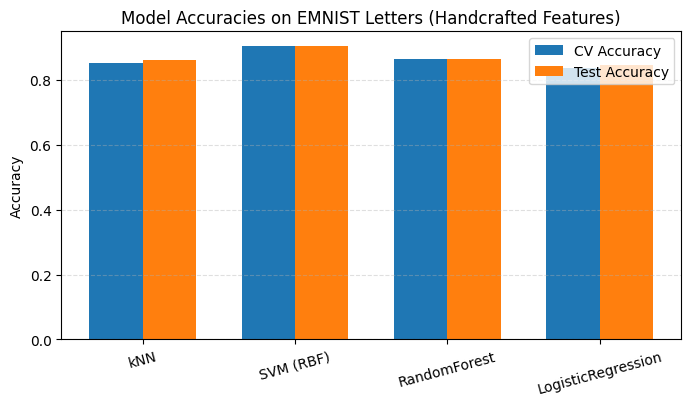

In [49]:
# Combine CV and test accuracy into a simple bar plot
model_names = list(models.keys())
cv_vals = [cv_results[m] for m in model_names]
test_vals = [test_accuracies[m] for m in model_names]

results_df = pd.DataFrame({"Model": model_names, "CV Accuracy": cv_vals, "Test Accuracy": test_vals})
display(results_df)

x = np.arange(len(model_names))
width = 0.35

plt.figure(figsize=(8, 4))
plt.bar(x - width/2, cv_vals, width, label="CV Accuracy")
plt.bar(x + width/2, test_vals, width, label="Test Accuracy")
plt.xticks(x, model_names, rotation=15)
plt.ylabel("Accuracy")
plt.title("Model Accuracies on EMNIST Letters (Handcrafted Features)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()


# 6. Detailed Metrics for the Best Model

In [50]:
# Find best model by test accuracy
best_model_name = max(test_accuracies, key=test_accuracies.get)
best_model = models[best_model_name]

print(f"Best model: {best_model_name}, Test accuracy = {test_accuracies[best_model_name]:.4f}")

# Predict on test set
y_pred_best = best_model.predict(X_test)

acc = accuracy_score(y_test, y_pred_best)
f1 = f1_score(y_test, y_pred_best, average='macro')
print(f'Hold-out accuracy: {acc:.4f}')
print(f'Macro F1-score: {f1:.4f}')

print("\nClassification Report:")
print(classification_report(
    y_test,
    y_pred_best,
    target_names=[idx_to_char(i) for i in range(26)]
))


Best model: SVM (RBF), Test accuracy = 0.9032
Hold-out accuracy: 0.9032
Macro F1-score: 0.9028

Classification Report:
              precision    recall  f1-score   support

           A       0.81      0.93      0.87       165
           B       0.92      0.90      0.91       147
           C       0.95      0.96      0.95       158
           D       0.93      0.94      0.93       149
           E       0.94      0.95      0.95       147
           F       0.97      0.94      0.95       156
           G       0.77      0.68      0.72       146
           H       0.90      0.89      0.90       147
           I       0.69      0.72      0.71       151
           J       0.90      0.94      0.92       156
           K       0.95      0.92      0.94       157
           L       0.78      0.71      0.74       154
           M       0.98      0.95      0.97       151
           N       0.90      0.93      0.92       152
           O       0.95      0.97      0.96       148
           P    

# 6.1 Confusion Matrix Heatmap

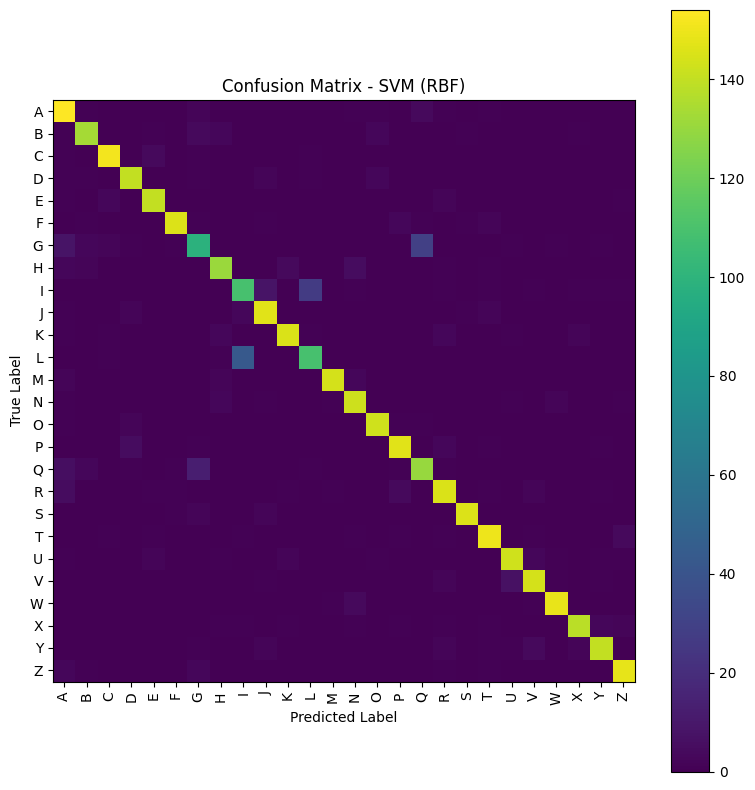

In [51]:
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation="nearest")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.colorbar()
tick_marks = np.arange(26)
plt.xticks(tick_marks, [idx_to_char(i) for i in range(26)], rotation=90)
plt.yticks(tick_marks, [idx_to_char(i) for i in range(26)])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


### Why these handcrafted features?
- **LBP histograms** capture local texture strokes and work well for thin handwriting lines.
- **HOG descriptors** summarize gradient orientation structure, giving the model shape cues similar to classical OCR.
- **Edge density + connected components** quantify how dense and fragmented the strokes are, which helps differentiate letters such as 'E' vs. 'F'.

Together they provide complementary texture and shape information, which is why the best-performing model tends to favor them over any single descriptor.


# 7. Model Inference & Evaluation – Show 5 Random Test Images

This section visualizes five random test samples with predicted vs. actual labels so we can qualitatively inspect mistakes.


/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/usr/local/lib/python3

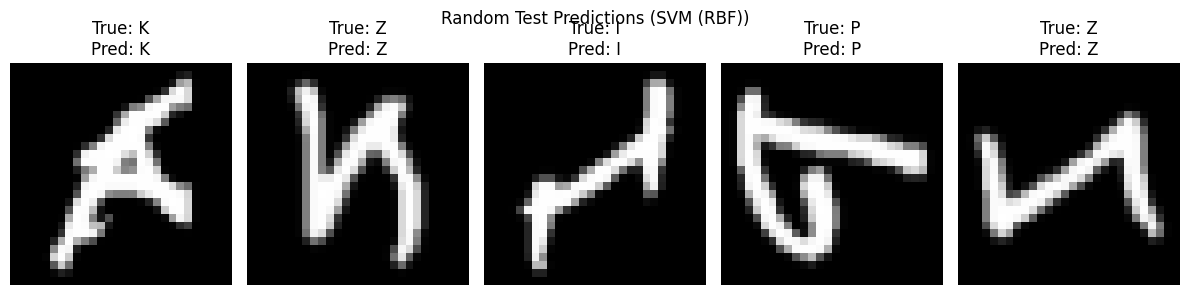

In [52]:
# 7. Visual evaluation on 5 random test images

def show_random_predictions(num_samples=5):
    """
    Pick 'num_samples' random test images and display Actual vs Predicted labels.
    Each call gives different images.
    """
    # Randomly pick indices
    indices = np.random.choice(len(X_test_imgs), size=num_samples, replace=False)

    plt.figure(figsize=(12, 3))

    for i, idx in enumerate(indices):
        img = X_test_imgs[idx]
        true_label = y_test[idx]

        # Extract features & predict
        feat = extract_features_single(img).reshape(1, -1)
        pred_label = best_model.predict(feat)[0]

        # Plot image
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(f"True: {idx_to_char(true_label)}\nPred: {idx_to_char(pred_label)}")

    plt.suptitle(f"Random Test Predictions ({best_model_name})")
    plt.tight_layout()
    plt.show()


show_random_predictions()


# 8. Validation of Actual Test – Your Own Handwritten Letter

Upload or draw one handwritten letter image (white background preferred), then run the helper cell below to preprocess and evaluate it. Document whether the prediction matches your intent and discuss lighting/noise if it fails.


## 8.1 Function to Process an External Image

In [53]:
from PIL import Image

def preprocess_external_image(path, invert=True):
    """
    Load an external handwritten letter image, convert it to the same format
    as the training data (upright EMNIST orientation), and extract features.
    """
    # Load image with PIL
    img = Image.open(path).convert("L")  # convert to grayscale

    # Resize to 28x28 (EMNIST size)
    img = img.resize((28, 28))

    # Convert to numpy array
    img_np = np.array(img).astype("float32")

    # Depending on background (white vs black), we may need to invert
    if invert:
        img_np = 255.0 - img_np

    # Normalize to [0,1]
    img_np = img_np / 255.0

    return img_np

def predict_external_image(path, invert=True):
    img_28x28 = preprocess_external_image(path, invert=invert)
    features = extract_features_single(img_28x28).reshape(1, -1)
    pred_label = best_model.predict(features)[0]
    pred_char = idx_to_char(pred_label)

    plt.figure(figsize=(3, 3))
    plt.imshow(img_28x28, cmap="gray")
    plt.axis("off")
    plt.title(f"Predicted: {pred_char}")
    plt.show()

    return pred_char

# To evaluate your own handwritten letter, place it in the repo root (e.g., 'my_letter.png')
# and run the next cell.


/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


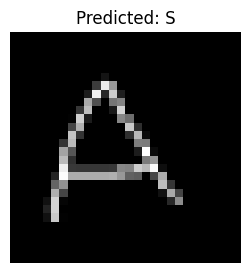

/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Model prediction for a.png: S


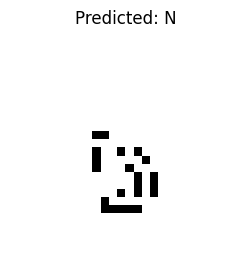

Model prediction for b.png: N
Sample k.png not found; add your handwritten letter to test real-world performance.


/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


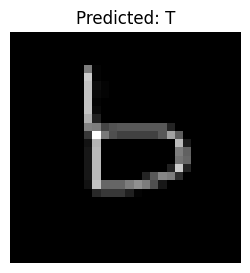

Model prediction for abc.png: T


In [56]:
# Evaluate one or more handwritten samples if they exist locally
candidate_files = [

    Path("a.png"),
    Path("b.png"),

    Path("k.png"),

    Path("abc.png"),
]

for path in candidate_files:
    if path.exists():
        pred = predict_external_image(path, invert=True)
        print(f"Model prediction for {path.name}: {pred}")
    else:
        print(f"Sample {path} not found; add your handwritten letter to test real-world performance.")


(Reserved for additional handwritten samples. Reuse the evaluation cell above with your own file names.)
